Let's try a more difficult problem that hopefully offers an opportunity to use snorkel's more advanced features. I'm using English dataset to make it easier to replicate the approaches in the snorkel tutorials.

https://www.kaggle.com/danofer/sarcasm/version/4 is a dataset of Reddit posts including the string '/s' to indicate the user is being sarcastic. Can snorkel identify these posts?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import snorkel

%matplotlib inline
from IPython.core.pylabtools import figsize

The Kaggle dataset includes a separate test set, but it's not clearly labeled so let's just split the test data which is about a million posts.


In [2]:
df = pd.read_csv("/Users/awhite/Downloads/sarcasm/train-balanced-sarcasm.csv")

df.comment = df.comment.apply(str)
df.comment = df.comment.str.lower()
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc and nh.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,you do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"they were underdogs earlier today, but since g...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"this meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,i could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2, random_state = 0)
train, dev = train_test_split(train, test_size = 0.1, random_state = 0)
valid, dev = train_test_split(dev, test_size = 0.5, random_state = 0)

Y_train = train["label"].values
Y_dev = dev["label"].values
Y_valid = valid["label"].values
Y_test = test["label"].values

In [4]:
train.label.value_counts()

1    364136
0    363658
Name: label, dtype: int64

In [4]:
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function

POS = 1
NEG = 0
ABSTAIN = -1

In [6]:
pd.set_option("display.max_colwidth", 0)

dev.comment[dev.label == 1].sample(20)

727789    she's dead!                                                                                      
500760    nah, they're shit m8                                                                             
907270    that's exactly what i said.                                                                      
531991    0 abs * 2 = 0 abs                                                                                
445389    i'm going to give them a gold star                                                               
167816    it's basically confirmed now                                                                     
708669    just like you can't know grammar                                                                 
353468    and it is people like you that makes the community better, nice one                              
492352    ahh good ol retreads ....                                                                        
763264    "but when we say w

In [7]:
@labeling_function()
def clearly(x):
    return POS if re.search("not \w+ at all|rarely|clearly|totally|obviously|come on|logically|literally|surely|undoubtedly", x.comment)  else ABSTAIN

@labeling_function()
def pass_ag(x):
    return POS if re.search("great job|fine job|can't wait|i'm sure", x.comment) else ABSTAIN

@labeling_function()
def indignant(x):
    return POS if re.search("how dare|sir|ma'am|miss", x.comment) else ABSTAIN

@labeling_function()
def always(x):
     return POS if re.search("best|worst|always|never|100%", x.comment) else ABSTAIN

@labeling_function()
def thanks(x):
     return NEG if re.search("thank you|appreciate it|helpful|so kind", x.comment) else ABSTAIN
    
@labeling_function()
def asterisks(x):
    return POS if re.search("\*\w+\*", x.comment) else NEG

In [8]:
lfs = [clearly, pass_ag, indignant,
       always, thanks, asterisks]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train)
L_dev = applier.apply(df=dev)
L_valid = applier.apply(df=valid)
L_test = applier.apply(df=test)

100%|██████████| 202166/202166 [00:32<00:00, 6151.50it/s]


In [9]:
from snorkel.labeling.analysis import LFAnalysis

LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
clearly,0,[1],0.033191,0.033191,0.032028,1121,221,0.835320
pass_ag,1,[1],0.008211,0.008211,0.008063,288,44,0.867470
indignant,2,[1],0.008904,0.008904,0.008829,216,144,0.600000
always,3,[1],0.036604,0.036604,0.035788,811,669,0.547973
thanks,4,[0],0.003314,0.003314,0.000198,85,49,0.634328
asterisks,5,"[0, 1]",1.000000,0.087206,0.082012,345,0,0.501422


In [10]:
from snorkel.analysis.error_analysis import get_label_buckets

buckets = get_label_buckets(Y_dev, L_dev[:, 1])
dev.comment.iloc[buckets[(POS, ABSTAIN)]].sample(10)

817623    needs more pixels... 2/10 would not bang                                                     
313575    ethan must have lost a lot of skins for him to hunt this information down                    
19195     where would i be on your rating system                                                       
817842    it's actually a 16 gb tablet with 1 gb left for user storage after the touchwiz installation.
318219    when i found christ                                                                          
272906    thanks man, i never noticed it.                                                              
320480    there were two topless women with them but they were thrown out.                             
584049    skase, pousth.                                                                               
288371    everyone not believing flat earth theory of course                                           
684318    yes, there are plenty of people breeding - just not pe

score


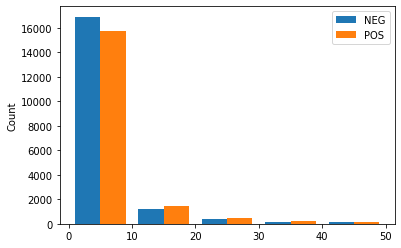

ups


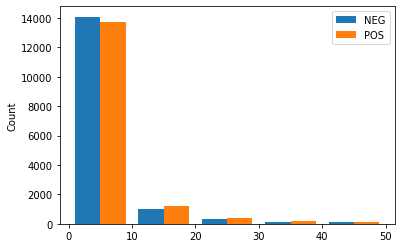

downs


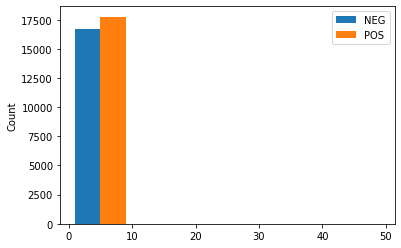

In [11]:
for item in ['score','ups','downs']:
    zero_scores = dev[item][dev.label == 0]

    one_scores = dev[item][dev.label == 1]

    plt.hist([zero_scores, one_scores], bins=[0,10,20,30,40,50])
    plt.ylabel("Count")
    plt.legend(["NEG", "POS"])
    print(item)
    plt.show()

In [26]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter

stops = stopwords.words('english') + list(string.punctuation)
strings = ' '.join(dev.parent_comment[dev.label == 1]).lower()
unigrams = [i for i in word_tokenize(strings) if i not in stops]

Counter(unigrams).most_common()[:40]

[("'s", 5205),
 ("n't", 4804),
 ('``', 2444),
 ("''", 2442),
 ('like', 2109),
 ('people', 2003),
 ('would', 1861),
 ('...', 1820),
 ('get', 1609),
 ('one', 1427),
 ("'m", 1210),
 ('think', 1151),
 ("'re", 1024),
 ('know', 989),
 ('even', 916),
 ('really', 875),
 ('game', 844),
 ('time', 822),
 ('good', 811),
 ('could', 765),
 ('see', 730),
 ('make', 716),
 ('want', 705),
 ('go', 649),
 ('right', 647),
 ('got', 642),
 ('also', 639),
 ("'ve", 634),
 ('still', 622),
 ('something', 620),
 ('going', 618),
 ('ca', 614),
 ('way', 613),
 ('us', 601),
 ('new', 591),
 ('much', 588),
 ('someone', 573),
 ('well', 570),
 ('never', 565),
 ('first', 543)]

In [14]:
print(''.join(dev.comment[dev.label == 0]).count("lol"),
      ''.join(dev.comment[dev.label == 1]).count("lol")
     )

print(''.join(dev.comment[dev.label == 0]).count("haha"),
      ''.join(dev.comment[dev.label == 1]).count("haha")
     )

print(''.join(dev.comment[dev.label == 0]).count("!!"),
      ''.join(dev.comment[dev.label == 1]).count("!!")
     )

print(''.join(dev.comment[dev.label == 0]).count("!?"),
      ''.join(dev.comment[dev.label == 1]).count("!?")
     )

233 119
123 299
25 6
2 0


In [6]:
#Adjusting LFs based on these results

@labeling_function()
def clearly1(x):
    return POS if re.search("totally|obviously|clearly", x.comment)  else ABSTAIN

@labeling_function()
def clearly2(x):
    return POS if re.search("not \w+ at all|rarely|come on|logically|literally|surely|undoubtedly", x.comment)  else ABSTAIN

@labeling_function()
def pass_ag(x):
    return POS if re.search("great job|fine job|can't wait", x.comment) else ABSTAIN

@labeling_function()
def indignant(x):
    return POS if re.search("how dare|sir|ma'am|miss|but, but", x.comment) else ABSTAIN

@labeling_function()
def always(x):
     return POS if re.search("best|worst|always|never|100%|impossible", x.comment) else ABSTAIN

@labeling_function()
def thanks(x):
     return NEG if re.search("thank you|appreciate it|helpful|so kind", x.comment) else ABSTAIN
    
@labeling_function()
def asterisks(x):
    return POS if re.search("\*\w+\*", x.comment) else ABSTAIN

@labeling_function()
def funny(x):
    if re.search("lol", x.comment):
        return NEG
    elif re.search("haha", x.comment):
        return POS
    else:
        return ABSTAIN

#Tried a few iterations of this, but it wasn't very accurate
@labeling_function()
def emoji(x):
    return POS if re.search(r"xd|\:p|-_-|ー_ー|-\.-|=_=|－‸ლ|¯\_(ツ)_/¯", x.comment) else ABSTAIN

In [16]:
lfs = [clearly1, clearly2, pass_ag, indignant,
       always, thanks, asterisks, funny]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train)
L_dev = applier.apply(df=dev)
L_valid = applier.apply(df=valid)
L_test = applier.apply(df=test)

100%|██████████| 202166/202166 [00:50<00:00, 3977.43it/s]


In [17]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
clearly1,0,[1],0.025994,0.002646,0.000198,941,110,0.895338
clearly2,1,[1],0.007321,0.000841,0.000049,185,111,0.625000
pass_ag,2,[1],0.001756,0.000000,0.000000,54,17,0.760563
indignant,3,[1],0.009324,0.000989,0.000124,232,145,0.615385
always,4,[1],0.037568,0.002993,0.000272,836,683,0.550362
thanks,5,[0],0.003314,0.000198,0.000198,85,49,0.634328
asterisks,6,[1],0.014147,0.002201,0.000074,345,227,0.603147
funny,7,"[0, 1]",0.011896,0.000693,0.000519,279,202,0.580042


In [18]:
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel

majority_model = MajorityLabelVoter()
Y_pred_train = majority_model.predict(L=L_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=1000, lr=0.001, log_freq=100, seed=123)

majority_acc = majority_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")
label_model_acc = label_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   51.9%
Label Model Accuracy:     51.8%


This seems like a case where dropping empty rows would certainly improve performance, because even a human can't identify some of these comments as sarcastic without context - let's check

In [19]:
from snorkel.labeling.utils import filter_unlabeled_dataframe
from snorkel.analysis.utils import probs_to_preds

Y_probs_train = label_model.predict_proba(L=L_train)

train_filtered, Y_probs_train_filtered = filter_unlabeled_dataframe(
    X=train, y=Y_probs_train, L=L_train)

Y_preds_train_filtered = probs_to_preds(probs=Y_probs_train_filtered)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

words_train = [row.comment for i, row in train_filtered.iterrows()]
words_valid = [row.comment for i, row in valid.iterrows()]
words_test = [row.comment for i, row in test.iterrows()]

vectorizer = CountVectorizer(ngram_range=(2,2))
X_train = vectorizer.fit_transform(words_train)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier().fit(X_train, Y_preds_train_filtered)

classifier.score(X_test, Y_test)            

0.4983330530356242

In [21]:
Y_preds_train = probs_to_preds(probs=Y_probs_train)

words_train = [row.comment for i, row in train.iterrows()]
words_valid = [row.comment for i, row in valid.iterrows()]
words_test = [row.comment for i, row in test.iterrows()]

vectorizer = CountVectorizer(ngram_range=(2,2))
X_train = vectorizer.fit_transform(words_train)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier().fit(X_train, Y_preds_train)

classifier.score(X_test, Y_test)  

0.4952464806149402

Let's also try the transformation function examples that snorkel describes here: https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/02_spam_data_augmentation_tutorial.ipynb

They're reproduced below with minimal changes

In [ ]:
! python -m spacy download en_core_web_sm

In [22]:
from snorkel.preprocess.nlp import SpacyPreprocessor

In [23]:
spacy = SpacyPreprocessor(text_field="comment", doc_field="doc", memoize=True)

In [24]:
import names
from snorkel.augmentation.tf import transformation_function

In [25]:
replacement_names = [names.get_full_name() for _ in range(50)]

# Replace a random named entity with a different entity of the same type.
@transformation_function(pre=[spacy])
def change_person(x):
    person_names = [ent.text for ent in x.doc.ents if ent.label_ == "PERSON"]
    # If there is at least one person name, replace a random one. Else return None.
    if person_names:
        name_to_replace = np.random.choice(person_names)
        replacement_name = np.random.choice(replacement_names)
        x.comment = x.comment.replace(name_to_replace, replacement_name)
        return x


# Swap two adjectives at random.
@transformation_function(pre=[spacy])
def swap_adjectives(x):
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    # Check that there are at least two adjectives to swap.
    if len(adjective_idxs) >= 2:
        idx1, idx2 = sorted(np.random.choice(adjective_idxs, 2, replace=False))
        # Swap tokens in positions idx1 and idx2.
        x.comment = " ".join(
            [
                x.doc[:idx1].text,
                x.doc[idx2].text,
                x.doc[1 + idx1 : idx2].text,
                x.doc[idx1].text,
                x.doc[1 + idx2 :].text,
            ]
        )
        return x

In [27]:
from snorkel.augmentation.apply import PandasTFApplier
from snorkel.augmentation.policy import MeanFieldPolicy

tfs = [change_person, swap_adjectives]

policy = MeanFieldPolicy(
    len(tfs),
    sequence_length=2,
    n_per_original=2,
    keep_original=True,)

tf_applier = PandasTFApplier(tfs, policy)
train_augmented = tf_applier.apply(train)
Y_train_augmented = train_augmented["label"].values


100%|██████████| 727794/727794 [5:04:06<00:00, 39.89it/s]     


In [28]:
print(f"Original training set size: {len(train)}")
print(f"Augmented training set size: {len(train_augmented)}")

Original training set size: 727794
Augmented training set size: 953714


In [8]:
train_augmented.to_csv("/Users/awhite/Downloads/augmented.csv")

In [9]:
lfs = [clearly1, clearly2, pass_ag, indignant,
       always, thanks, asterisks, funny]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train_augmented)
L_dev = applier.apply(df=dev)
L_valid = applier.apply(df=valid)
L_test = applier.apply(df=test)


 11%|█         | 106350/953714 [00:29<03:29, 4038.20it/s]


 23%|██▎       | 216304/953714 [00:56<02:54, 4231.44it/s]


 34%|███▍      | 323378/953714 [01:24<02:50, 3689.13it/s]


 45%|████▌     | 430374/953714 [01:52<02:14, 3902.30it/s]


 56%|█████▌    | 535787/953714 [02:19<01:46, 3912.13it/s]


 67%|██████▋   | 643264/953714 [02:47<01:20, 3858.45it/s]


 79%|███████▉  | 751608/953714 [03:14<00:49, 4098.58it/s]


 90%|█████████ | 859982/953714 [03:41<00:23, 3948.24it/s]


 30%|██▉       | 12033/40433 [00:03<00:07, 4013.94it/s]


 17%|█▋        | 34071/202166 [00:10<00:54, 3079.64it/s]


 73%|███████▎  | 146680/202166 [00:38<00:16, 3273.75it/s]


100%|██████████| 202166/202166 [00:54<00:00, 3677.80it/s]

In [11]:
majority_model = MajorityLabelVoter()
Y_pred_train = majority_model.predict(L=L_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=1000, lr=0.001, log_freq=100, seed=123)

majority_acc = majority_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")
label_model_acc = label_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   51.9%
Label Model Accuracy:     51.8%


In [13]:
Y_probs_train = label_model.predict_proba(L=L_train)

Y_preds_train = probs_to_preds(probs=Y_probs_train)

words_train = [row.comment for i, row in train_augmented.iterrows()]
words_valid = [row.comment for i, row in valid.iterrows()]
words_test = [row.comment for i, row in test.iterrows()]

vectorizer = CountVectorizer(ngram_range=(2,2))
X_train = vectorizer.fit_transform(words_train)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier().fit(X_train, Y_preds_train)

classifier.score(X_test, Y_test)  

0.4989266246549865

No improvement in performance, although the snorkel tutorial that I copied these TFs from also did not show an improvement after augmenting data - and that was using tensorflow. Maybe TFs aren't actually useful, at least in some cases? Or maybe more thought needs to be put into the TFs that make sense for specific datasets? Or maybe the underlying problem here is a lack of decent LFs?

Can we test the power of the augmented training data by itself by training on our actual labeled data, instead of the LF-generated labels?

In [17]:
words_train = [row.comment for i, row in train.iterrows()]
words_valid = [row.comment for i, row in valid.iterrows()]
words_test = [row.comment for i, row in test.iterrows()]

vectorizer = CountVectorizer(ngram_range=(2,2))
X_train = vectorizer.fit_transform(words_train)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier().fit(X_train, Y_train)

classifier.score(X_test, Y_test)  

0.6615306233491289

In [19]:
Y_train_augmented = train_augmented["label"].values

words_train = [row.comment for i, row in train_augmented.iterrows()]
words_valid = [row.comment for i, row in valid.iterrows()]
words_test = [row.comment for i, row in test.iterrows()]

vectorizer = CountVectorizer(ngram_range=(2,2))
X_train = vectorizer.fit_transform(words_train)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier().fit(X_train, Y_train_augmented)

classifier.score(X_test, Y_test)  

0.6713839122305432